# PPO
---

### 1. Import the Necessary Packages

In [1]:
from model.ppo import PPO
from env.wrappers import *
from env.ant_disturbances import *
from utils.logger import WandbSummaryWritter
import torch
from networks.mlp import MLP

### 2. Instantiate the Model

Setup the hyperparameters in the code cell below.

In [22]:
# hyperparameters = {
#     'timesteps_per_batch': 1024 ,                # Number of timesteps to run per batch
#     'max_timesteps_per_episode': 1200,           # Max number of timesteps per episode
#     'n_updates_per_iteration': 5,                # Number of times to update actor/critic per iteration
#     'lr': 2.5e-4 ,                                # Learning rate of actor optimizer
#     'gamma': 0.95,                               # Discount factor to be applied when calculating Rewards-To-Go
# }
# hyperparameters = {'gamma': 0.999, 'lr_gamma': 0.995,
#                    'max_timesteps_per_episode': 1200,'lr': 0.005 }

hyperparameters = {}

misc_hyperparameters = {
    'env': Ant,
    'activation': torch.nn.Tanh,
    'base_encoder_class': MLP,
    'env_args': {
        'env_class': AntEnv,
        'known_disturbances':False
    }
}

Initialise wandb session in the code cell below.

In [3]:
LOG = False
if LOG:
    logger = WandbSummaryWritter(project='ant', config =misc_hyperparameters['env']().load_hyperparameters())
else:
    logger=None

Initialise the model fo the desired timestamps. Alternatively can specify a checkpoint to continue training.

In [26]:
checkpoint = 'ppo_checkpoints/ant_test2'
# checkpoint = 'ppo_checkpoints/ant-1'
LOAD_MODEL = True

ppo = PPO(logger, **hyperparameters, **misc_hyperparameters)

if LOAD_MODEL:
    ppo.policy.load_state_dict(torch.load(checkpoint + "/base.pth"))
    # ppo.adpt_module.load_state_dict(torch.load(checkpoint + "/adp_model.pth"))
    # ppo.adapt_policy.set_policy(ppo.policy)

### 3. Train the Model

Train model for specified amount of timestamps.

In [5]:
ppo.train()
# ppo.train_adaptive_module()


-------------------- Iteration 1/1 --------------------
Average Episodic Return: -237.31
Average Loss: 41.5991
Average KL Divergence: 0.03579644836389066
Iteration took: 21.93 secs, of which rollout took 17.74 secs and gradient updates took 4.17 secs
Current learning rate: 0.005
------------------------------------------------------



### 4. Evaluate the Model

Run multiple episodes from pretrained model.

In [17]:
import os
i = 3
path = f"C:\\Users\\pmsar\\git\\tum-adlr-ws25-16\\ppo_checkpoints\\ant_test{i}"
os.makedirs(path, exist_ok=True)
torch.save(ppo.policy.state_dict(), path + "\\base.pth")
# torch.save(ppo.adpt_module.state_dict(), path + "\\adpt.pth")
# ppo.test(False)

In [27]:

import numpy as np
MAX_IT = 25
val_t = np.zeros(MAX_IT)
val_rew = np.zeros(MAX_IT)
ppo.policy.cpu()
env = ppo.env_class(num_envs=1, **ppo.env_args)
for i in  range(0, MAX_IT):
        obs, done = env.reset()
        model = env.envs[0].model
        t = 1
        reward = 0
        while not done[0] and t < 1_000:
            action = ppo.policy.sample_action(torch.Tensor(obs))
            obs, rew, done = env.step(action.numpy())
            t+=1
            reward+=rew
        val_t[i] = t
        val_rew[i] =reward
print(np.mean(val_t), np.mean(val_rew))
#752.86 1538.6648483656134

926.52 4035.35165645688


In [7]:
import os
os.environ["MUJOCO_GL"] = "wgl"
env.close()
ppo.policy.cpu()
env = ppo.env_class(num_envs=1, render_mode="human", **ppo.env_args)
while True:
    obs, done = env.reset()
    model = env.envs[0].model
    t = 1
    while not done[0] and t < 1_000:
        action = ppo.policy.sample_action(torch.Tensor(obs))
        obs, _, done = env.step(action.numpy())
        t+=1

KeyboardInterrupt: 

In [16]:
ppo.adapt_policy.clear_history()

wind_vals = []
base_z = []
adpt_z = []

env = ppo.env_class(num_envs=1, render_mode='human')
obs, done = env.reset()

reward = 0
t = 0
while not done[0] and (obs[0][-2] == 0 or obs[0][-3] == 0):
    wind_vals.append(obs[0, -1])

    obs_tensor = torch.tensor(obs, dtype=torch.float32).to(ppo.device)
    action = ppo.adapt_policy.sample_action(obs_tensor)

    base_output = ppo.policy.encoder(obs_tensor).detach().cpu().numpy().flatten()[0]
    adpt_output = ppo.adapt_policy.encode(obs_tensor).detach().cpu().numpy().squeeze()[-1]

    base_z.append(base_output)
    adpt_z.append(adpt_output)
    obs, rew, done = env.step(action.cpu().numpy())
    reward += rew
    t+=1
    if t % 1000 == 0:
        print(t, reward)
print(t, reward)
print(wind_vals[0], base_z[0])

240 [143.3314202]
-8.736527 0.34947306


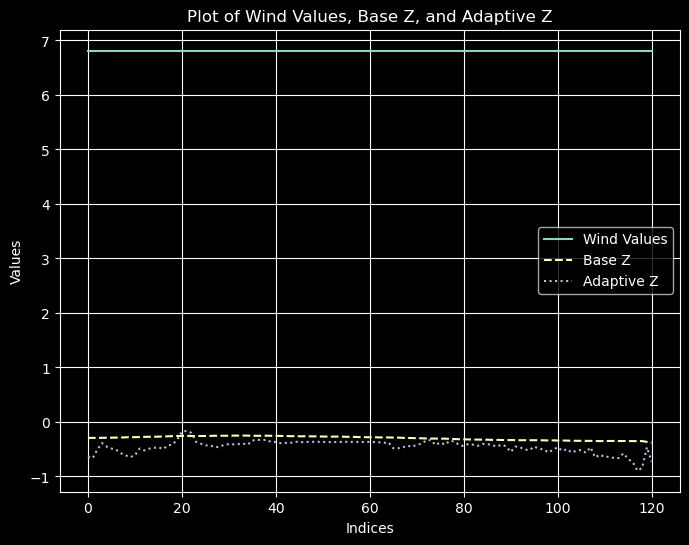

In [10]:
import matplotlib.pyplot as plt

# wind_vals, base_z, adpt_z = ppo.validate_encoders_single_rollout()
indices = range(len(wind_vals))

plt.figure(figsize=(8, 6))
plt.plot(indices, base_z, label="Base Z", linestyle='--')
plt.plot(indices, adpt_z, label="Adaptive Z", linestyle=':')

plt.xlabel("Timestep")
plt.ylabel("Encoder Output")
plt.title(f"Output throughout a single rollout with wind_power={wind_vals[0]}")
plt.legend()
plt.grid(True)

plt.show()

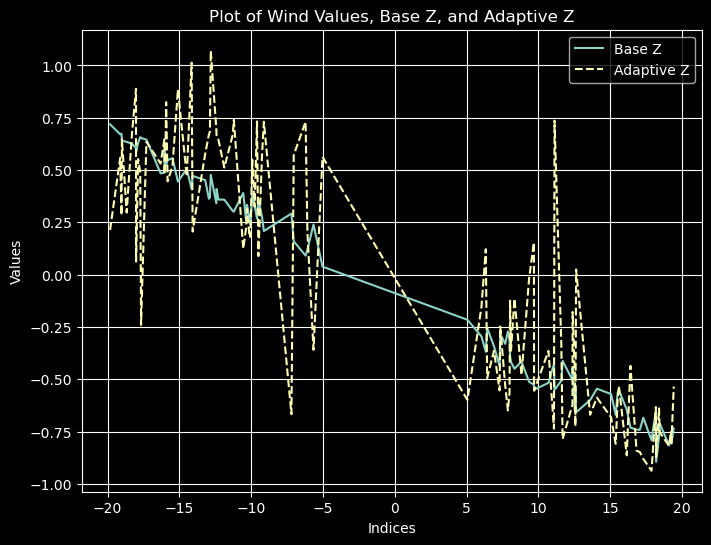

In [11]:
import numpy as np
t_winds, b_z, a_z = ppo.validate_encoders(100, 100)
sorted_indices = np.argsort(t_winds)
plt.figure(figsize=(8, 6))
plt.plot(t_winds[sorted_indices], b_z[sorted_indices], label="Base Z")
plt.plot(t_winds[sorted_indices], a_z[sorted_indices], label="Adaptive Z", linestyle='--')

plt.xlabel("Indices")
plt.ylabel("Values")
plt.title("Plot of Wind Values, Base Z, and Adaptive Z")
plt.legend()
plt.grid(True)

plt.show()